In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

In [3]:
class SimpleSignal (torch.utils.data.Dataset):
    def __init__(self):
        super(SimpleSignal, self).__init__()
        self.data, self.labels = self.generate_data()
        self.train_ix, self.validation_ix, self.test_ix = self.get_ix_splits()
        
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.data)
    
    def get_ix_splits(self):
        split_props = [0.8, 0.1, 0.1] # train/ test / validation split proportions
        indices = range(len(self.data))
        
        # split_points returns [0.8 * len(self.data), 0.1 * len(self.data), 0.1 * len(self.data)]
        split_points = [int(len(self.data) * i) for i in split_props]
        
        train_ix = np.random.choice(indices, 
                                   split_points[0],
                                   replace = False)
        
        
        test_ix = np.random.choice(list(set(indices) - set(train_ix)),
                                  split_points[1],
                                  replace = False)
        
        validation_ix = np.random.choice(list(set(indices) - set(train_ix) - set(test_ix)),
                                        split_points[2],
                                        replace = False)
    
        return train_ix, test_ix, validation_ix
        
    def generate_data(self):
        
        data = []
        labels = []
        data1 = open('ItalyPowerDemand_TRAIN')
        lines1 = data1.readlines()
        data2 = open('ItalyPowerDemand_TEST')
        lines2 = data2.readlines()
        
        # EXTRACTING THE LABELS
        
        firstNumber1 = [i[0] for i in lines1]
        labels.append(firstNumber1)
        firstNumber2 = [i[0] for i in lines2]
        labels.append(firstNumber2)
        
        # adding the label lists from both training and testing 
        labels = labels[0] + labels[1]
        labels = list(map(int, labels))
        
        # convert from 1 to 0, from 2 to 1
        for i in range(len(labels)):
            if labels[i] == 1:
                labels[i] = 0
            else:
                labels[i] = 1
        
        # EXTRACTING THE DATA
        lines = lines1 + lines2
        
        # i is the line #
        for i in range(len(lines)):
            line = np.asarray(lines[i].split(','))
            tempData = []
            
            for j in range(1, len(line)):
                elem = float(line[j])
                tempData.append(elem)
            
            data.append(tempData)
            
        '''
        print("Raw data: ")
        for i in lines:
            print(i)
        print("Labels: ", labels)
        print()
        print("Data: ", data)
        '''
        
        dataTensor = torch.tensor(data, dtype = torch.float).unsqueeze(2)
        labelsTensor= torch.tensor(labels, dtype = torch.long)
        
        print(np.shape(dataTensor))
        print(np.shape(labelsTensor))
        
        return dataTensor, labelsTensor
    

In [4]:
# --- Model architecture and training ---

HIDDEN_DIMENSION = 20
N_LAYERS_VECTOR = [1, 3]
BATCH_SIZE = 10
N_EPOCHS = 28
LEARNING_RATE = [.05, .1]

# --- Data generation parameters ---

N_FEATURES = 1
N_CLASSES = 2

# training set into 10 batches 
# each has 80 objects

# --- create the dataset ---
data = SimpleSignal()


ones = 0

for i in range(len(data)):
    # print
    if (data.labels[i] == 1):
        ones += 1
        
zeros = len(data) - ones
        
print('proportion of ones: ', ones / len(data))
print('proportion of zeroes: ', zeros / len(data))


torch.Size([1096, 24, 1])
torch.Size([1096])
proportion of ones:  0.5009124087591241
proportion of zeroes:  0.4990875912408759


In [5]:
# --- define the data loaders ---
train_sampler = SubsetRandomSampler(data.train_ix) # Random sampler for training indices
validation_sampler = SubsetRandomSampler(data.validation_ix) # Random sampler for validation indices
test_sampler = SubsetRandomSampler(data.test_ix) # Random sampler for testing indices


# drop_last = True to drop the last incomplete batch, if the dataset size is not
# divisible by the batch size
train_loader = torch.utils.data.DataLoader(dataset=data,
                                           batch_size=BATCH_SIZE, 
                                           sampler=train_sampler,
                                           shuffle=False, drop_last = True)

validation_loader = torch.utils.data.DataLoader(dataset= data,
                                               batch_size = BATCH_SIZE, 
                                               sampler = validation_sampler,
                                               shuffle = False, drop_last = True)

test_loader = torch.utils.data.DataLoader(dataset=data,
                                          batch_size=BATCH_SIZE, 
                                          sampler=test_sampler,
                                          shuffle=False, drop_last = True)

# --- define your model here ---
class RNN(nn.Module):
    def __init__(self, HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE):
        super(RNN, self).__init__()
        self.N_LAYERS = N_LAYERS
        self.BATCH_SIZE = BATCH_SIZE
        self.HIDDEN_DIMENSION = HIDDEN_DIMENSION
        self.N_CLASSES = N_CLASSES
        
        # --- define mappings here ---
        self.lstm = torch.nn.LSTM(N_FEATURES, HIDDEN_DIMENSION, N_LAYERS)       #sets up initial weight matrices
        self.out = torch.nn.Linear(HIDDEN_DIMENSION, N_CLASSES)
        #nonlinear part - tells probabilites
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, X):  #X is input data - tensor shape = (batch size, input dimension)
        # --- define forward pass here ---
        #initialize hidden state - need to do this because this is an RNN/LSTM (you use torch.nn.LSTM above)
        state = (torch.zeros(N_LAYERS, BATCH_SIZE, self.HIDDEN_DIMENSION), # h_0 initial hidden state
                 torch.zeros(N_LAYERS, BATCH_SIZE, self.HIDDEN_DIMENSION)) # c_0 initial cell state
        X = torch.transpose(X, 0, 1)  #should have shape timesteps, batch_size, num features
        
        hidden, state = self.lstm(X, state)   #X is timeseries, shape is (timesteps, batch size)
        #hidden = h_t = hidden cell sate after w1 weight matrix (self.LSTM has been applied to the current cell) = this is actually vector containing all h_t's for each cell
        #state = (h_n, c_n) = h_n is hidden state that depends on all previous cells, c_n is cell state that depends on all previous cells
        output = self.out(hidden[-1])   #cell's hidden state gets passed thru w2 (out) weight matrix to produce output
        prediction = self.softmax(output)
        return prediction

In [6]:
loss_plotting_training_lr = []
accuracy_plotting_training_lr = []
loss_plotting_validation_lr = []
accuracy_plotting_validation_lr = []

# loop over the number of layers
for nl in range(len(N_LAYERS_VECTOR)):
    N_LAYERS = N_LAYERS_VECTOR[nl]

    # looping over the learning rate
    for i_lr in range(len(LEARNING_RATE)):


        # --- initialize the model and the optimizer ---
        model = RNN(HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS_VECTOR[nl], BATCH_SIZE)
        optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE[i_lr]) 
        # Using the Adam optimizer - don't worry about the details, it's going to update the network's weights.
        criterion = torch.nn.CrossEntropyLoss()   #defining loss function
        
        
        # Instantiate step learning scheduler class
        
        scheduler = StepLR(optimizer, step_size = 1, gamma = 0.1)

        # --- training the model ---

        loss_vector_training=[]
        accuracy_vector_training=[]
        loss_vector_validation = []
        accuracy_vector_validation = []
        for epoch in range(N_EPOCHS):
            
            scheduler.step()
            
            # Decay Learning Rate
            
            loss_sum = 0

            predictions_sum = 0
            labels_sum = 0
            for i, (time_series, labels) in enumerate(train_loader): # Iterate through the training batches

                # --- Forward pass ---
                predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)

                #zero gradients, can also do model.zero_grad() in this case
                optimizer.zero_grad()   

                for i in range(10):
                    predict = predictions[i,1]
                    if predict <=.5:
                        estimate=0
                    else:
                        estimate=1
                    if estimate==labels[i]:
                        predictions_sum += 1
                    labels_sum += 1

                # --- Compute gradients and update weights ---
                # criterion is the cross entropy loss function
                loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
                loss_sum += loss.item()

                loss.backward(retain_graph = True)
                optimizer.step()  #updates parameters using Adam alg rather than grad descent
                #if (i+1) % 1 == 0:
                #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, i+1, len(train_loader), loss.item()))
            accuracy = predictions_sum/labels_sum
            loss_total = loss_sum/ 87
            accuracy_vector_training.append(accuracy)
            loss_vector_training.append(loss_total)
            
            # --- Validation ---
            

            vtotal = 0
            for i, (time_series, labels) in enumerate(validation_loader):
                predictions_sum = 0
                labels_sum = 0
                predictions = model(time_series) #time_series has shape 10 by 1 (batch_size x input dimension)
                vtotal += 10
                
                for i in range(10):
                    predict = predictions[i, 1]
                    if predict <= .5:
                        estimate = 0
                    else:
                        estimate = 1
                    if estimate==labels[i]:
                        predictions_sum += 1
                    labels_sum += 1
                    
                loss = criterion(predictions, labels)
                loss_sum += loss.item()
            loss_total = loss_sum/vtotal
            accuracy = predictions_sum / labels_sum
            loss_vector_validation.append(loss_total)
            accuracy_vector_validation.append(accuracy)

        loss_plotting_validation_lr.append(loss_vector_validation)
        accuracy_plotting_validation_lr.append(accuracy_vector_validation)
            
        loss_plotting_training_lr.append(loss_vector_training)
        accuracy_plotting_training_lr.append(accuracy_vector_training)
        
        print('accuracy: ', accuracy)
        print ('Loss for each Epoch:','Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, N_EPOCHS, loss_total))
        print('Learning rate: ', LEARNING_RATE[i_lr], 'Number of layers: ', N_LAYERS_VECTOR[nl])

accuracy:  1.0
Loss for each Epoch: Epoch [28/28], Training Loss: 0.3402
Learning rate:  0.05 Number of layers:  1
accuracy:  1.0
Loss for each Epoch: Epoch [28/28], Training Loss: 0.3408
Learning rate:  0.1 Number of layers:  1
accuracy:  0.9
Loss for each Epoch: Epoch [28/28], Training Loss: 0.3490
Learning rate:  0.05 Number of layers:  3
accuracy:  1.0
Loss for each Epoch: Epoch [28/28], Training Loss: 0.3446
Learning rate:  0.1 Number of layers:  3


In [7]:
#testing
loss_plotting_testing_lr = []
accuracy_plotting_testing_lr = []

for i_lr in range(len(LEARNING_RATE)):

    loss_vector_testing=[]
    accuracy_vector_testing=[]
    for i, (time_series, labels) in enumerate(test_loader): # Iterate through the testing set, 10 timeseries in 10 batches (100 timeseries total)
            predictions_sum = 0
            labels_sum = 0
            loss_sum = 0
            predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)

            for i in range(10):
                predict = predictions[i,1]
                if predict <=.5:
                    estimate=0
                else:
                    estimate=1
                if estimate==labels[i]:
                    predictions_sum += 1
                labels_sum += 1
            loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
            loss_sum += loss.item()
            accuracy = predictions_sum/labels_sum
            loss_vector_testing.append(loss_sum)
            accuracy_vector_testing.append(accuracy)
            print('accuracy: ', accuracy)
            print('loss: ', loss_sum)
    loss_plotting_testing_lr.append(loss_vector_testing)
    accuracy_plotting_testing_lr.append(accuracy_vector_testing)


accuracy:  1.0
loss:  0.3276221752166748
accuracy:  1.0
loss:  0.33842864632606506
accuracy:  1.0
loss:  0.3411112129688263
accuracy:  1.0
loss:  0.35784491896629333
accuracy:  0.9
loss:  0.38254475593566895
accuracy:  1.0
loss:  0.3209725618362427
accuracy:  0.9
loss:  0.43128514289855957
accuracy:  0.9
loss:  0.3604573607444763
accuracy:  1.0
loss:  0.3519115149974823
accuracy:  1.0
loss:  0.32369333505630493
accuracy:  1.0
loss:  0.3741275668144226
accuracy:  1.0
loss:  0.3493512272834778
accuracy:  0.9
loss:  0.36324775218963623
accuracy:  1.0
loss:  0.34992069005966187
accuracy:  1.0
loss:  0.33855709433555603
accuracy:  1.0
loss:  0.3185402452945709
accuracy:  0.9
loss:  0.42830246686935425
accuracy:  1.0
loss:  0.31610944867134094
accuracy:  1.0
loss:  0.33965837955474854
accuracy:  0.9
loss:  0.3671921491622925


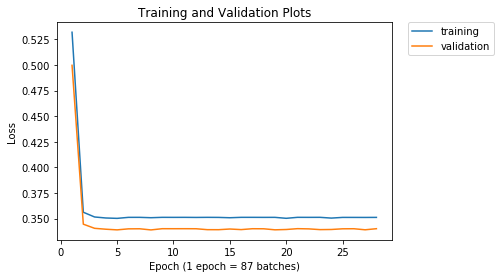

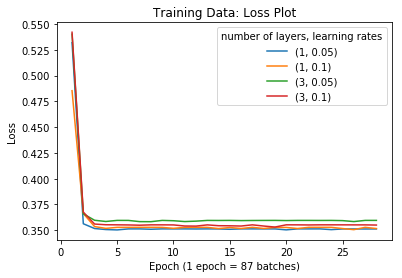

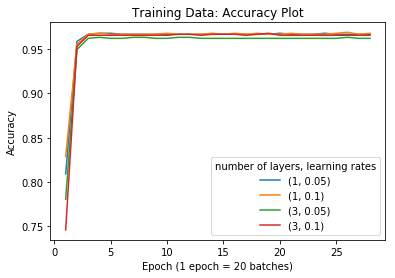

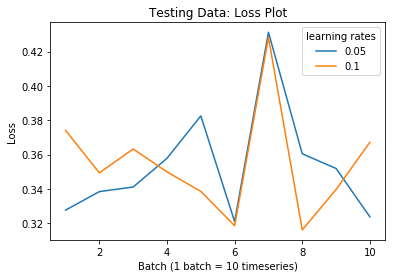

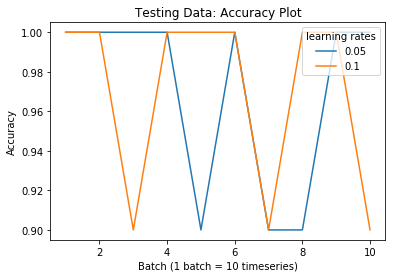

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

legend_vector = []
for nl in N_LAYERS_VECTOR:
    for lr in LEARNING_RATE:
        legend_vector.append( (nl, lr))

learning_vector = []
for lr in LEARNING_RATE:
        learning_vector.append(lr)

epochs_vector = [i for i in range(1, N_EPOCHS + 1)]

# plt.gca().set_color_cycle(['red', 'blue'])
# plt.plot(epochs_vector, loss_plotting_validation_lr[0])

plt.plot(epochs_vector, loss_plotting_training_lr[0], label = "training")
plt.plot(epochs_vector, loss_plotting_validation_lr[0], label = "validation")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Training and Validation Plots")
plt.ylabel('Loss')
plt.xlabel('Epoch (1 epoch = 87 batches)')
plt.show();

# this is doing the same thing as 
# plt.plot(epochs_vector, accuracy_dif_lr[0])
# plt.plot(epochs_vector, accuracy_dif_lr[1])
# plt.plot(epochs_vector, accuracy_dif_lr[2])
for YAxis in loss_plotting_training_lr:
    plt.plot(epochs_vector, YAxis)
plt.legend([t for t in legend_vector], loc='upper right', title='number of layers, learning rates')
plt.title('Training Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch (1 epoch = 87 batches)')
plt.show();

for YAxis in accuracy_plotting_training_lr:
    plt.plot(epochs_vector, YAxis)
plt.legend([t for t in legend_vector], loc='lower right', title="number of layers, learning rates")
plt.title('Training Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch (1 epoch = 20 batches)')
plt.show();

batch_vector = [i for i in range(1, 11)]

for YAxis in loss_plotting_testing_lr:
    plt.plot(batch_vector, YAxis)
plt.legend([t for t in learning_vector], loc = 'upper right', title = "learning rates")
plt.title('Testing Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Batch (1 batch = 10 timeseries)')
#plt.axis([0, 10, .3, .646])
plt.show();

for YAxis in accuracy_plotting_testing_lr:
    plt.plot(batch_vector, YAxis)
plt.legend([t for t in learning_vector], loc = 'upper right', title = "learning rates")
plt.title('Testing Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Batch (1 batch = 10 timeseries)')
#plt.axis([0, 10, .654, 1.022])
plt.show();
